In [ ]:
! pip install -q kaggle

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 2.4 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=eff8f5ca37f752f453e43e4c4973474a39b63c679c097c73d41d5bbeae993c43
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download histopathologic-cancer-detection

100% 6.30G/6.31G [02:24<00:00, 98.0MB/s]
100% 6.31G/6.31G [02:24<00:00, 46.7MB/s]


In [ ]:
! unzip histopathologic-cancer-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: train/fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: train/fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: train/fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: train/fa2f1d5e86165f63c57acdf9d23521f2b8070e0c.tif  
  inflating: train/fa2ffa

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.linear_model import Perceptron, SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

import zipfile 

In [ ]:
current_path = '/content/'
train_path = current_path + 'train_labels.csv'

train_dir = current_path + 'train/'
test_dir = current_path + 'test/'

# load the training data
train = pd.read_csv(train_path, dtype='str')
# make the label value integer
train['label'] = train['label'].astype('uint8')

# add the images extensions
train['id'] = train['id']+ '.tif'
print(len(train))
train.head(5)

220025


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


The image shape:  (96, 96, 3)


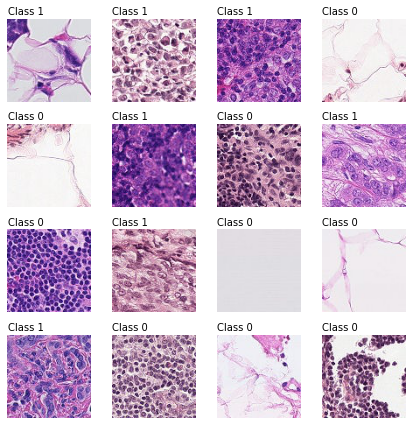

In [ ]:
# view sample data
sample = train.sample(n=16).reset_index()
plt.figure(figsize=(6,6)) # specifying the overall grid size

for i, row in sample.iterrows():  
    # a (96, 96, 3) image shape
    img = mpimg.imread(f'{train_dir}{row.id}')
    label = row.label
    plt.subplot(4,4,i+1)    # the number of images in the grid is 6*6 (16)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')
    plt.axis('off')

print('The image shape: ', img.shape)
plt.tight_layout()
plt.show()

In [ ]:
# display the count of the two classes
print('1 classes: ', len(train[train['label'] == 1]))
print('0 classes: ', len(train[train['label'] == 0]))

# so the data is biased to the 0 class
# make a balance between these two classes
sample_size = 10000

train_0 = train[train['label'] == 0].sample(sample_size, random_state=1)
train_1 = train[train['label'] == 1].sample(sample_size, random_state=1)

# now lets merge the two classes again into the same training set
train_set = pd.concat([train_0, train_1], axis=0).reset_index(drop=True)

# shuffle the data
train = shuffle(train_set)

train['label'].value_counts()

1 classes:  89117
0 classes:  130908


1    10000
0    10000
Name: label, dtype: int64

In [ ]:
train_df, valid_df = train_test_split(train, test_size=0.20, random_state=1, stratify=train.label)

print(train_df.shape)
print(valid_df.shape)

train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)

train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

BATCH_SIZE = 64

train_loader = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = '/content/train/',
    target_size = (96, 96),
    x_col = "id",
    y_col = "label",
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
)

valid_loader = train_datagen.flow_from_dataframe(
    dataframe = valid_df,
    directory = '/content/train/',
    x_col = 'id',
    y_col = 'label',
    batch_size = BATCH_SIZE,
    seed = 1,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (96, 96)
)

(16000, 2)
(4000, 2)
Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.


# Define the sequential model

In [ ]:

cnn_model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(96,96,3)),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None),
    Dropout(0.25),
    BatchNormalization(),

    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None),
    Dropout(0.25),
    BatchNormalization(),

    Flatten(),
    
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(16, activation='relu'),
    Dropout(0.25),
    BatchNormalization(),
    Dense(2, activation='softmax')
])
 

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 average_pooling2d (AverageP  (None, 48, 48, 32)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        1

In [ ]:
opt = tf.keras.optimizers.Adam(0.0001)
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy',tf.keras.metrics.AUC()]
)

h1 = cnn_model.fit(
    x = train_loader,
    epochs = 10,
    validation_data = valid_loader, 
    verbose = 1
)

Epoch 1/10
250/250 [==============================] - 742s 3s/step - loss: 0.6201 - accuracy: 0.7041 - auc_1: 0.7691 - val_loss: 2.6848 - val_accuracy: 0.5000 - val_auc_1: 0.5891
Epoch 2/10
250/250 [==============================] - 734s 3s/step - loss: 0.5286 - accuracy: 0.7621 - auc_1: 0.8340 - val_loss: 3.2524 - val_accuracy: 0.5123 - val_auc_1: 0.5555
Epoch 3/10
250/250 [==============================] - 730s 3s/step - loss: 0.4927 - accuracy: 0.7846 - auc_1: 0.8543 - val_loss: 1.4986 - val_accuracy: 0.6097 - val_auc_1: 0.6653
Epoch 4/10
250/250 [==============================] - 739s 3s/step - loss: 0.4807 - accuracy: 0.7856 - auc_1: 0.8612 - val_loss: 0.6158 - val_accuracy: 0.7678 - val_auc_1: 0.8402
Epoch 5/10
250/250 [==============================] - 736s 3s/step - loss: 0.4513 - accuracy: 0.8033 - auc_1: 0.8785 - val_loss: 0.5623 - val_accuracy: 0.7545 - val_auc_1: 0.8248
Epoch 6/10
250/250 [==============================] - 770s 3s/step - loss: 0.4448 - accuracy: 0.8064 - au

In [ ]:
# save the model
cnn_model.save('histopathologic-cancer-detection-cnn.h5')

dict_keys(['loss', 'accuracy', 'auc_1', 'val_loss', 'val_accuracy', 'val_auc_1'])



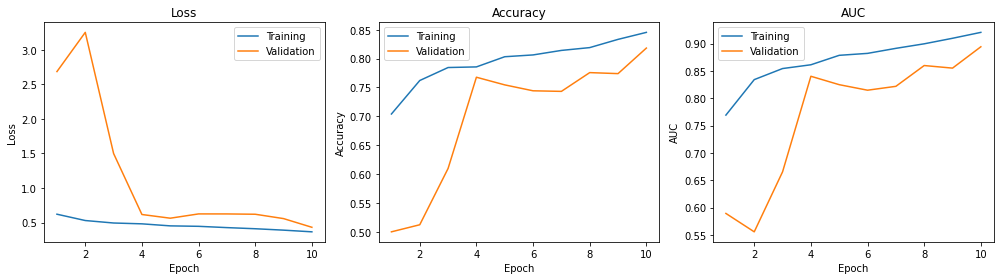

In [ ]:
history = h1.history
print(history.keys())
print()

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,3,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,3,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.subplot(1,3,3)
plt.plot(epoch_range, history['auc_1'], label='Training')
plt.plot(epoch_range, history['val_auc_1'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('AUC'); plt.title('AUC')
plt.legend()
plt.tight_layout()
plt.show()
